In [1]:
%matplotlib inline
import pandas as pd
from mpl_toolkits.basemap import Basemap
import numpy as np
from utilities import timestamps
from utilities.plotting import equi
from utilities.polygon_selection import get_node_data
from utilities.stats import calc_fmd_stats_with_mc
import matplotlib.pyplot as plt
from scipy import spatial
from itertools import product


In [2]:
max_slip = (130.9372, 32.84189)
fm_main = (130.763, 32.7545)#, 128, 74, -14)
high_b = (131.25, 33.15,)
low_b = (130.5, 32.5)
n_iterations = 1000
location_name = 'low_b'
location = low_b


radii = np.arange(1, 30, 1.)
timii = pd.date_range(start='01-01-1990 00:00:00', end='01-01-2015 00:00:00', freq='6M', tz='GMT')

parameters = [x for x in product(radii, timii)]

In [3]:
m_standard = Basemap(projection='merc', lon_0=0)

def get_cumdist(data):
    hist, edges = np.histogram(a=data, bins=100, range=(0,10))
    chist = np.cumsum(hist[::-1])
    return edges, hist, chist

def plot_data_with_fit_line(ax, raw_data, chist, radius, **kwargs):
    a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
    label = radius + ', b={b}, mc={mc}, n={n}'.format(b=round(b,4),mc=mc,n=n)
    ax.scatter(chist[0][::-1][:-1], chist[2], label=label, **kwargs)
#     a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
    x = np.arange(0, 10, 0.1)
    y = 10**(a - b * x)
    ax.plot(x, y, color='black')

def create_grid(axis_1_min_max, axis_2_min_max, axis_3_min_max
                , axis_1_increment, axis_2_increment, axis_3_increment\
               , columns=['longitude', 'latitude', 'depth']):
    axis_1_min, axis_1_max = axis_1_min_max
    axis_2_min, axis_2_max = axis_2_min_max
    axis_3_min, axis_3_max = axis_3_min_max

    axis_1_numpoints = (axis_1_max - axis_1_min)/axis_1_increment + 1
    axis_2_numpoints = (axis_2_max - axis_2_min)/axis_2_increment + 1
    axis_3_numpoints = (axis_3_max - axis_3_min)/axis_3_increment + 1


    axis_1 = np.linspace(axis_1_min, axis_1_max, axis_1_numpoints)
    axis_2 = np.linspace(axis_2_min, axis_2_max, axis_2_numpoints)
    axis_3 = np.linspace(axis_3_min, axis_3_max, axis_3_numpoints)

    axis123 = list(product(axis_1, axis_2, axis_3))
    grid = pd.DataFrame(axis123, columns=columns)
    return grid

def get_node_data(node, radius, data, m=m_standard):
#     m = Basemap(projection='robin', lon_0=0)
    node_lon = node[0]
    node_lat = node[1]
    radius = radius
    distance_from_node = (radius + 10)/111.133
    data = data[data.lon.between(node_lon-distance_from_node, node_lon+distance_from_node)
              & data.lat.between(node_lat-distance_from_node, node_lon+distance_from_node)].copy()
    xy = np.array(m(data.lon.values, data.lat.values)).transpose()
    node_xy = np.array([m(node_lon, node_lat)])
#     dist = scipy.spatial.distance.cdist(xy, node_xy)/1000. #cdist is meters, we want km
    dist = spatial.distance.cdist(xy, node_xy)/1000. #cdist is meters, we want km
    data['distance'] = dist[:,0]
    data = data[data.distance <= radius]
    return data

def mc_maximum_curvature(magnitudes):
    """
    :param catalog : pandas Series
    :param method : string
    """
    minimum = round(magnitudes.min(), 2)
    bins = np.arange(start=minimum, stop=10, step=0.1)
    hist, edges = np.histogram(a=magnitudes, range=(minimum, 10), bins=bins)
    hist_maximum_index = np.argmax(hist)
    return round(edges[hist_maximum_index], 2)

def fmd_values(magnitudes, bin_width=0.1):
    """
    params magnitudes : numpy.array
    params bin_width : float

    returns a,b,bstd, n-values if above the earthquake count threshold
    else returns np.nans
    """
    length = magnitudes.shape[0]
    minimum = magnitudes.min()
    average = magnitudes.mean()
    b_value = (1 / (average - (minimum - (bin_width / 2)))) * np.log10(np.exp(1))

    square_every_value = np.vectorize(lambda x: x ** 2)
    b_stddev = square_every_value((magnitudes - average).sum()) / (length * (length - 1))
    b_stddev = 2.3 * np.sqrt(b_stddev) * b_value ** 2
    a_value = np.log10(length) + b_value * minimum

    return a_value, b_value, b_stddev, length

def calc_fmd_stats_with_mc(magnitudes):
    if len(magnitudes) > 0:
        mc = mc_maximum_curvature(magnitudes) + 0.2
        magnitudes = magnitudes[magnitudes >= mc]
        if len(magnitudes) > 0:
            fmd_stats = fmd_values(magnitudes)
            return fmd_stats + (mc,)
        else: return (np.nan, np.nan, np.nan, np.nan, np.nan)
    else:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
    
def node_pipeline(node, data, radius):
    node_data = get_node_data(node=node, data=data, radius=radius)
    statistics = calc_fmd_stats_with_mc(node_data.mag)
    return statistics

def grid_statistic_pipeline(grid, data, radius):
    stats = []
    for node in grid:
        stats.append(node_pipeline(node=node, data=data, radius=radius) + (node[0], node[1]))
    return np.array(stats)

def calc_bootstrapped_fmd_values(df, n_calculations):
    fmd_values = []
    for n in range(n_calculations):
        fmd_values.append(calc_fmd_stats_with_mc(df.ix[np.random.choice(df.index, size=(1, len(df)))[0]].mag))
    return fmd_values

def get_catalog_shifted_by_location_mag_normal_error(df):
    err_df = df.copy()
    err_df['hz_err_deg'] = err_df['horizontal_error'] / 111.113
    err_df['lon'] = np.random.normal(err_df['lon'].values, err_df['hz_err_deg'].values+0.001)
    err_df['lat'] = np.random.normal(err_df['lat'].values, err_df['hz_err_deg'].values+0.001)
#     err_df['mag'] = np.random.normal(err_df['mag'], 0.1)
    return err_df

In [4]:
# df['hz_err_deg'] = df['horizontal_error'] / 111.113

# np.random.normal(df['lon'].values, df['hz_err_deg'].values+0.001)

In [5]:
# np.random.normal(4, 3)

In [6]:
df = pd.read_csv('data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])

In [7]:
df['timestamp'] = df.decimal_year.apply(timestamps.convert_decimal_year_to_numpy_datetime64)

In [8]:
foreshock_time = '2016-04-14 12:26:00'
mainshock_time = '2016-04-15 16:24:28'

# start_date = '2000-01-01 00:00:00'
# df = df[df.timestamp >= start_date]

# df = df[df.timestamp >= '2000-01-01 00:00:00']
# df = df[df.timestamp >= '2001-10-01 00:00:00']
df = df[df.timestamp < foreshock_time]
df = df[df.depth <= 25]
df = df[df.mag >= 0.5]

In [9]:
df = df.set_index('timestamp')

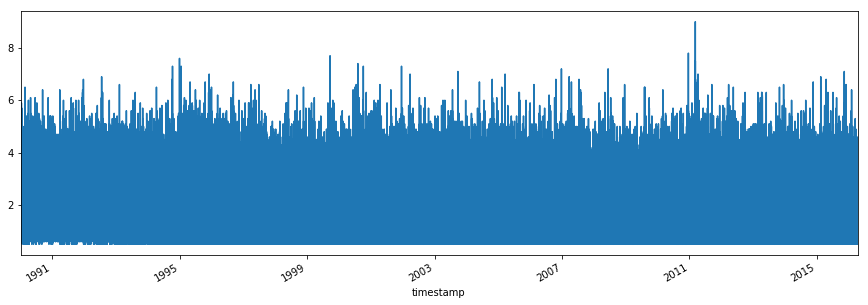

In [10]:
df.mag.plot(figsize=(15,5))

In [11]:
# from itertools import product

# radii = np.arange(1, 30, 0.5)
# timii = pd.date_range(start='01-01-1990 00:00:00', end='01-01-2015 00:00:00', freq='1M', tz='GMT')

# parameters = [x for x in product(radii, timii)]

In [12]:
fm_main = (130.763, 32.7545, 128, 74, -14)

local_df = df[df.lon.between(128, 132) & df.lat.between(30, 34)].copy()

rows = []

for r, t in parameters:
    raw_df = local_df.loc[local_df.index>=t].copy()
    raw_df = get_node_data(data=raw_df, radius=r, node=location)
    try:
        b = calc_bootstrapped_fmd_values(get_catalog_shifted_by_location_mag_normal_error(raw_df), n_iterations)
        bdf = pd.DataFrame(np.array(b), columns=['a', 'b', 'bstd', 'n', 'mc'])
        row = [(r,), (t,), bdf.mean().values, bdf.std().values]
        row = np.concatenate(np.array(row))
    except ValueError:
        row = (r,) + (t,)+(np.nan,)*10
    rows.append(row)
    

# for r, t in parameters:
#     raw_df = local_df.loc[local_df.index>=t].copy()
#     raw_df = get_node_data(data=raw_df, radius=r, node=location)
#     b = calc_bootstrapped_fmd_values(get_catalog_shifted_by_location_mag_normal_error(raw_df), n_iterations)
#     bdf = pd.DataFrame(np.array(b), columns=['a', 'b', 'bstd', 'n', 'mc'])
#     row = [(r,), (t,), bdf.mean().values, bdf.std().values]
#     row = np.concatenate(np.array(row))
#     rows.append(row)
    

bdf = pd.DataFrame(rows, columns=['radius', 'start_time', 'a_avg', 'b_avg', 'bstd_avg', 'n_avg', 'mc_avg'
                                         ,'a_std', 'b_std', 'bstd_std', 'n_std', 'mc_std'])
bdf[['radius', 'a_avg', 'b_avg', 'bstd_avg', 'n_avg', 'mc_avg'
    ,'a_std', 'b_std', 'bstd_std', 'n_std', 'mc_std']] = bdf[['radius', 'a_avg'
                                                              , 'b_avg', 'bstd_avg'
                                                              , 'n_avg', 'mc_avg'
                                                              , 'a_std', 'b_std'
                                                              , 'bstd_std', 'n_std'
                                                              , 'mc_std']].apply(pd.to_numeric)
bdf['start_time'] = pd.to_datetime(bdf['start_time'])

/home/max/anaconda2/envs/research/lib/python3.6/site-packages/ipykernel/__main__.py:78: RuntimeWarning: invalid value encountered in true_divide


In [13]:
bdf.describe()

,radius,a_avg,b_avg,bstd_avg,n_avg,mc_avg,a_std,b_std,bstd_std,n_std,mc_std
count,1450.000000,1384.000000,1384.000000,1.379000e+03,1384.000000,1384.000000,1.384000e+03,1.384000e+03,1.379000e+03,1384.000000,1.384000e+03
mean,15.000000,3.396973,0.951460,1.953632e-15,1014.989400,0.740771,2.849314e-01,1.945749e-01,1.162636e-15,25.170125,4.871681e-02
std,8.369487,0.840983,0.922691,1.950810e-15,1087.031165,0.069625,9.548144e-01,6.016149e-01,9.704957e-16,13.455463,5.876393e-02
min,1.000000,1.810092,0.636558,0.000000e+00,1.000000,0.700000,4.624076e-14,2.311600e-14,0.000000e+00,0.000000,6.442516e-15
25%,8.000000,2.986824,0.731205,6.733663e-16,189.688000,0.700200,1.446269e-02,1.881497e-02,5.287418e-16,18.140608,4.469897e-03
50%,15.000000,3.417801,0.771186,1.233487e-15,671.235500,0.701400,2.239872e-02,2.925868e-02,9.809153e-16,22.006906,1.527509e-02
75%,22.000000,3.718474,0.805070,2.509386e-15,1414.302750,0.753450,5.149671e-02,5.724324e-02,1.578966e-15,32.314293,9.158551e-02
max,29.000000,13.028834,8.685890,1.011144e-14,4546.784000,1.056636,7.564027e+00,3.516901e+00,1.226740e-14,76.562979,3.511938e-01


In [14]:
# import cProfile
# def do():
#     fm_main = (130.763, 32.7545, 128, 74, -14)

#     local_df = df[df.lon.between(128, 132) & df.lat.between(30, 34)].copy()

#     rows = []

#     for r, t in parameters:
#         raw_df = local_df.loc[local_df.index>=t].copy()
#         raw_df = get_node_data(data=raw_df, radius=r, node=fm_main[0:2])
#         b = calc_bootstrapped_fmd_values(get_catalog_shifted_by_location_mag_normal_error(raw_df), 10)
#         bdf = pd.DataFrame(np.array(b), columns=['a', 'b', 'bstd', 'n', 'mc'])
#         row = [(r,), (t,), bdf.mean().values, bdf.std().values]
#         row = np.concatenate(np.array(row))
#         rows.append(row)


#     bdf = pd.DataFrame(rows, columns=['radius', 'start_time', 'a_avg', 'b_avg', 'bstd_avg', 'n_avg', 'mc_avg'
#                                              ,'a_std', 'b_std', 'bstd_std', 'n_std', 'mc_std'])
#     bdf[['radius', 'a_avg', 'b_avg', 'bstd_avg', 'n_avg', 'mc_avg'
#         ,'a_std', 'b_std', 'bstd_std', 'n_std', 'mc_std']] = bdf[['radius', 'a_avg'
#                                                                   , 'b_avg', 'bstd_avg'
#                                                                   , 'n_avg', 'mc_avg'
#                                                                   , 'a_std', 'b_std'
#                                                                   , 'bstd_std', 'n_std'
#                                                                   , 'mc_std']].apply(pd.to_numeric)
#     bdf['start_time'] = pd.to_datetime(bdf['start_time'])

In [15]:
# cProfile.run('do()')

In [16]:
bdf.to_csv('radius_time_sweep_{n}.csv'.format(n=location_name), index=False)

In [17]:
bdf.head(1)

,radius,start_time,a_avg,b_avg,bstd_avg,n_avg,mc_avg,a_std,b_std,bstd_std,n_std,mc_std
0,1.0,1990-01-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(0.5, 1)

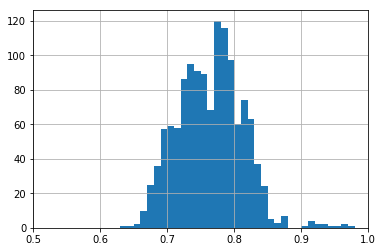

In [18]:
ax = bdf.b_avg.hist(bins=200, range=(0,2))
ax.set_xlim(0.5, 1)

/home/max/anaconda2/envs/research/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


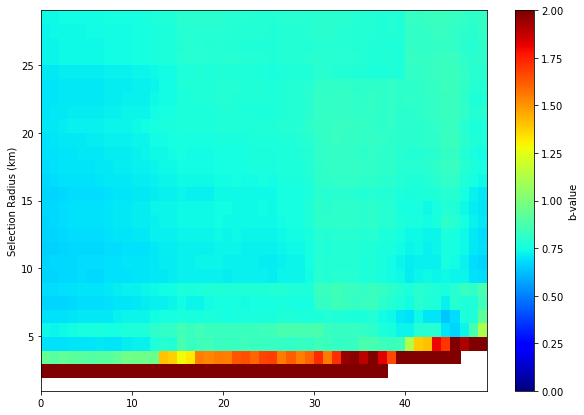

In [19]:
fig, ax = plt.subplots(figsize=(10,7))

zi = bdf.pivot(index='start_time', columns='radius', values='b_avg')
xi_label = [np.datetime64(z, 'Y') for z in zi.index]#
xi = np.arange(len(xi_label))
yi = zi.columns
xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi).transpose()

cbar = ax.pcolormesh(xi, yi, zi, vmin=0.0, vmax=2.0, cmap='jet')
fig.colorbar(cbar, label='b-value')

# ax.set_xticks(np.arange(0,300, 12))
# ax.set_xticklabels(xi_label[0::12], rotation=90)
ax.set_ylabel('Selection Radius (km)')

/home/max/anaconda2/envs/research/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/max/anaconda2/envs/research/lib/python3.6/site-packages/ipykernel/__main__.py:23: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


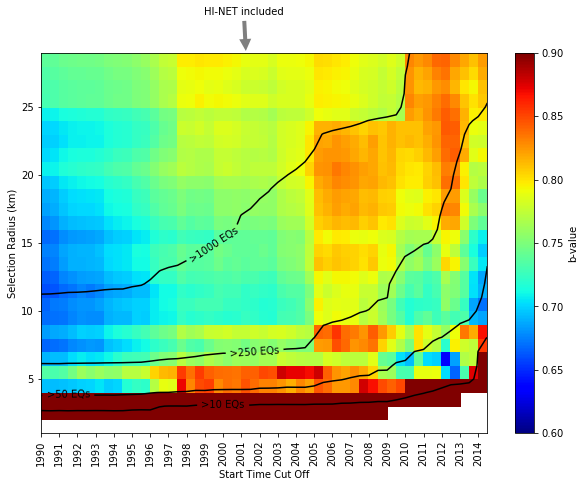

In [20]:
from matplotlib import colors, ticker, cm

fig, ax = plt.subplots(figsize=(10,7))

zi = bdf.pivot(index='start_time', columns='radius', values='b_avg')
xi_label = [np.datetime64(z, 'Y') for z in zi.index]
xi = np.arange(len(xi_label))
yi = zi.columns
xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi).transpose()

cbar = ax.pcolormesh(xi, yi, zi, vmin=0.6, vmax=0.9, cmap='jet')
fig.colorbar(cbar, label='b-value')

ax.set_xticks(np.arange(0, (2015-1990)*2, 2))
ax.set_xticklabels(xi_label[0::2], rotation=90)
ax.set_ylabel('Selection Radius (km)')

ax.annotate('HINET INCLUDED', xy=(25, 30), xytext=(130,25))

zi = bdf.pivot(index='start_time', columns='radius', values='n_avg')
xi_label = [np.datetime64(z, 'Y') for z in zi.index]
xi = np.arange(len(xi_label))
yi = zi.columns
xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi).transpose()


# from scipy.ndimage.filters import gaussian_filter
# zi = gaussian_filter(zi, .50)

# cs = ax.contour(xi,yi,zi, 80, colors='black', locator=ticker.LogLocator())
levels = [10, 50, 250, 1000, 5000]
cs = ax.contour(xi,yi,zi, levels, colors='black', locator=ticker.LogLocator())

cs.levels = ['>10 EQs', '>50 EQs','>250 EQs', '>1000 EQs', '>5000 EQs']

# ax.clabel(cs, cs.levels, inline=True, manual=[(25, 2), (25,3),(25, 5), (25, 12),  (17, 25)])
ax.clabel(cs, cs.levels, inline=True)



ax.annotate('HI-NET included',
            xy=(22.5, 29), xycoords='data', color='black',
            xytext=(22.75/50, 1.12), textcoords='axes fraction', annotation_clip=False,
            arrowprops=dict(facecolor='black', shrink=0.05, edgecolor='None', alpha=0.5),
            horizontalalignment='center', verticalalignment='top',)


ax.set_xlabel('Start Time Cut Off')

# def annotate_plot(ax, xy, s, xytext):
#     ax.annotate(s, xy=xy, xycoords='data', color='black'
# #                ,xytext=(xy[0]/300., 1.1), textcoords='axes fraction', annotation_clip=False
#                ,xytext=xytext, textcoords='axes fraction', annotation_clip=False
#                ,arrowprops=dict(facecolor='black', shrink=0.05, edgecolor='None', alpha=0.5),
#             horizontalalignment='center', verticalalignment='top', )

# eq_locations = get_node_data(node=fm_main[0:2], radius=30, data=df)
# geq_m4 = eq_locations[eq_locations.mag>4]['mag'].copy()
# [np.datetime64(g, 'M') for g in geq_m4.index]
# geq_x = [0+6, 0+12,12*2+7, 12*6+6, 12*7+4, 12*8+7, 12*9+11, 12*10+6, 12*12+5, 12*15+1, 12*17+3, 12*21+10]
# geq_label = ['M'+str(n) for n in geq_m4.values]
# geq = [x for x in zip(geq_x, geq_label)]
# n = 0
# for x, label in geq:
    
#     if n % 2 == 0:
        
#         annotate_plot(ax, xy=(x, 29), s=label, xytext=(x/300., 1.1))
        
#     else:
        
#         annotate_plot(ax, xy=(x, 29), s=label, xytext=(x/300., 1.15))

#     n+=1

In [21]:
eq_locations = get_node_data(node=fm_main[0:2], radius=30, data=df)
geq_m4 = eq_locations[eq_locations.mag>4]['mag'].copy()
[np.datetime64(g, 'M') for g in geq_m4.index]
geq_x = [0+6, 0+12,12*2+7, 12*6+6, 12*7+4, 12*8+7, 12*9+11, 12*10+6, 12*12+5, 12*15+1, 12*17+3, 12*21+10]
geq_label = ['M'+str(n) for n in geq_m4.values]
geq = [x for x in zip(geq_x, geq_label)]
geq

[(6, 'M4.1'),
 (12, 'M4.2'),
 (31, 'M4.4'),
 (78, 'M4.3'),
 (88, 'M4.1'),
 (103, 'M4.2'),
 (119, 'M4.2'),
 (126, 'M5.0'),
 (149, 'M4.1'),
 (181, 'M4.1'),
 (207, 'M4.1'),
 (262, 'M4.5')]

In [22]:
# zi = bdf.pivot(index='start_time', columns='radius', values='b_avg')
# xi_label = [np.datetime64(z, 'Y') for z in zi.index]
# zi.index

In [23]:
# 12*11

(0.5, 1)

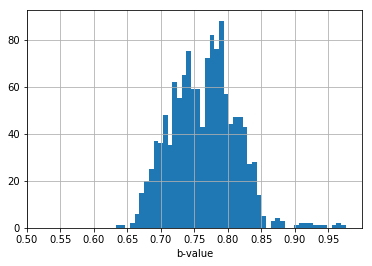

In [24]:
ax = bdf.b_avg.hist(bins=100, range=(0.5,1.2))
ax.set_xlabel('b-value')
ax.set_xticks(np.arange(0.5, 1.0, 0.05))
ax.set_xlim(0.5, 1)

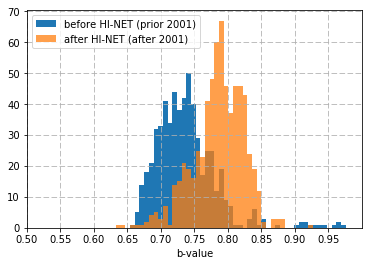

In [25]:
ax = bdf[bdf.start_time < '2001-01-01'].b_avg.hist(bins=100, range=(0.5,1.2), label='before HI-NET (prior 2001)')
bdf[bdf.start_time >= '2001-10-01'].b_avg.hist(bins=100, range=(0.5,1.2), ax=ax, alpha=0.75, label='after HI-NET (after 2001)')

ax.set_xlabel('b-value')
ax.set_xticks(np.arange(0.5, 1.0, 0.05))
ax.set_xlim(0.5, 1)
ax.legend()
ax.grid(linestyle='--')

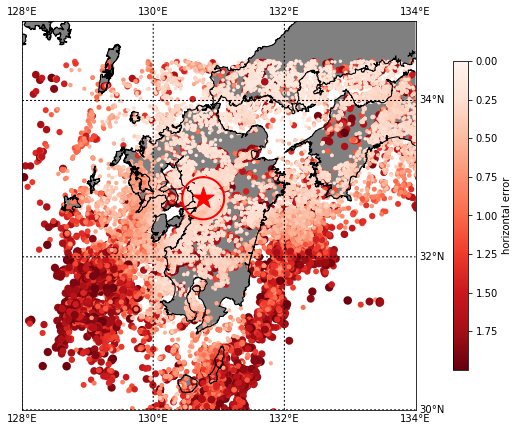

In [26]:
fig, ax = plt.subplots(1, figsize=(8,8))

m = Basemap(projection='merc'
           ,llcrnrlat=30
           ,urcrnrlat=35
           ,llcrnrlon=128.
           ,urcrnrlon=134
           ,resolution='f'
           ,area_thresh=100
           ,ax=ax)

labels = np.arange(0,180,2)
m.drawparallels(labels, labels=labels)
m.drawmeridians(labels, labels=labels)

m.drawcoastlines()
m.fillcontinents(color='gray', zorder=0)

# # data = df[(df.mag > 2.5) & df.lat.between(32,34) & df.lon.between(130,132)]
d = df[(df.mag > 1)].copy()
d = d[d.lat.between(28.5, 34.5) & d.lon.between(126.5, 134.5)]
d = d[d.horizontal_error <= 2.0]


x, y = m(d.lon.values, d.lat.values)

cbar = ax.scatter(x, y, c=d.horizontal_error.values, s=10*np.exp(d.horizontal_error.values), edgecolor='None'
                  , cmap='Reds')
c1 = fig.colorbar(cbar, label='horizontal error',fraction=0.0346, pad=0.084)
c1.ax.invert_yaxis()


x, y = m(fm_main[0], fm_main[1])
ax.scatter(x, y, s=500, marker='*', zorder=50, c='red')

# sizes = np.exp([3,4,5,6,7])
# label_plot = [ax.scatter([],[], s=s, edgecolors='black', color='white', alpha=0.5) for s in sizes]
# labels = [x for x in range(3,11)]
# ax.legend(label_plot, labels, ncol=10, frameon=True, fontsize=12, handlelength=0.75, loc='upper left'
#         , borderpad = 1.,handletextpad=0.95, title='Magnitude Size', scatterpoints = 1
#         , bbox_to_anchor=(0.18,0.0115))

equi(m, fm_main[0], fm_main[1], 30, lw=2, color='red')
# equi(m, 132, 32, 50, lw=2)
# equi(m, 130, 34, 50, lw=2, color='red')

/home/max/anaconda2/envs/research/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/max/anaconda2/envs/research/lib/python3.6/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


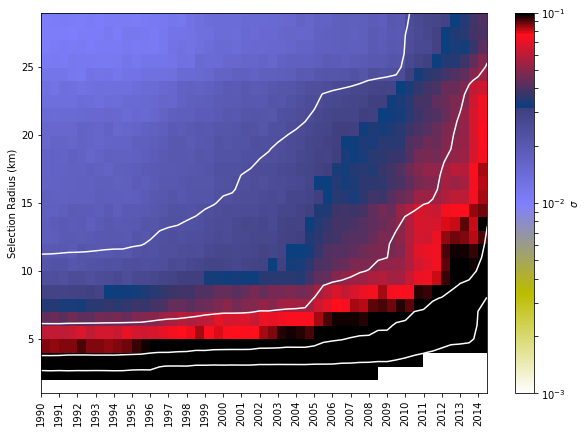

In [27]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(10,7))

zi = bdf[bdf['b_std'] > 0.].pivot(index='start_time', columns='radius', values='b_std')
xi_label = [np.datetime64(z, 'Y') for z in xi_label]#zi.index
xi = np.arange(len(xi_label))
yi = zi.columns
xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi).transpose()

cbar = ax.pcolormesh(xi, yi, zi, vmin=0.001, vmax=0.1, cmap='gist_stern_r', norm=LogNorm())

fig.colorbar(cbar, label=r'$\sigma$')

ax.set_xticks(np.arange(0, (2015-1990)*2, 2))
ax.set_xticklabels(xi_label[0::2], rotation=90)
ax.set_ylabel('Selection Radius (km)')

zi = bdf.pivot(index='start_time', columns='radius', values='n_avg')
xi_label = [np.datetime64(z, 'Y') for z in zi.index]
xi = np.arange(len(xi_label))
yi = zi.columns
xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi).transpose()


# from scipy.ndimage.filters import gaussian_filter
# zi = gaussian_filter(zi, .50)

# cs = ax.contour(xi,yi,zi, 80, colors='black', locator=ticker.LogLocator())
levels = [10, 50, 250, 1000, 5000]
cs = ax.contour(xi,yi,zi, levels, colors='white', locator=ticker.LogLocator())

cs.levels = ['>10 EQs', '>50 EQs','>250 EQs', '>1000 EQs', '>5000 EQs']


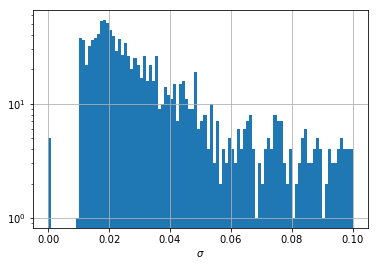

In [28]:
ax = bdf.b_std.hist(bins=100, range=(0,.1), log=True)
ax.set_xlabel('$\sigma$')

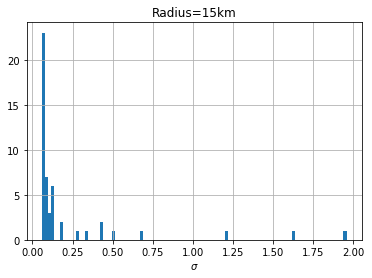

In [29]:
ax = bdf[bdf['radius']==5].b_std.hist(bins=100)
ax.set_xlabel('$\sigma$')
ax.set_title('Radius=15km')

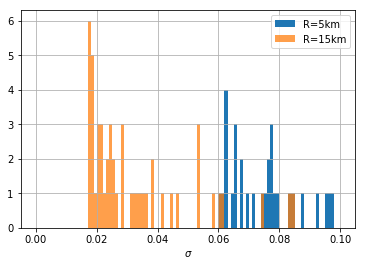

In [30]:
fig, ax = plt.subplots()
bdf[bdf['radius']==5].b_std.hist(bins=100, range=(0,0.1), ax=ax, label='R=5km')
bdf[bdf['radius']==15].b_std.hist(bins=100, range=(0, 0.1), ax=ax, label='R=15km', alpha=0.75)
ax.set_xlabel('$\sigma$')
ax.legend()